In [1]:
!nvidia-smi

Tue Nov  7 05:13:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3A:00.0 Off |                    0 |
| N/A   29C    P0    41W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings
warnings.filterwarnings(action="ignore")

In [3]:

import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.callbacks import RichProgressBar, TQDMProgressBar, ModelCheckpoint
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger


import logging
logging.basicConfig(level="INFO")

import math
from matplotlib import pyplot
%matplotlib inline

import numpy as np

import os

import pandas as pd
from pprint import pprint

import sys
sys.path.append("../src")

import timm
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary


In [4]:
%load_ext autoreload
%autoreload 2

In [73]:
import config
from dataloader import BEDataset, BEDataModule
from film_layers import FiLMEncoder
from token_learner import TokenLearnerV11
from transformer import PositionalEncoder, SelfAttentionHead, MultiHeadSelfAttention, FeedFowardLayer, LayerNormalization, TransformerDecoderLayer, TransformerDecoder, generate_causal_attention_mask

from rt1 import RT1Encoder, RT1Decoder, ActionGenerator, RT1
from utils.model_utils import TextEncoder, ImageFeatureExtractor, plot_attention, fetch_random_sample_from_batch, greedy_decoding, decode_predictions
import utils.data_utils as data_utils

In [6]:
dm = BEDataModule()
dm.setup()

INFO:root:Training on 3882 samples.
INFO:root:Validating on 626 samples.
INFO:root:Testing on 250 samples.


Total # examples: 4758


In [7]:
%%time
batch = next(iter(dm.train_dataloader()))
print(batch.keys())
batch["in_state"].shape

dict_keys(['sample_id', 'in_state', 'action_desc', 'source_mask_tokens', 'source_mask', 'motor_cmd', 'target_mask'])
CPU times: user 846 ms, sys: 905 ms, total: 1.75 s
Wall time: 6.74 s


torch.Size([2, 3, 288, 288])

In [8]:
input_ids=batch["action_desc"]["ids"].cuda()
attn_mask=batch["action_desc"]["mask"].cuda()
token_type_ids=batch["action_desc"]["token_type_ids"].cuda()
imgs=batch["in_state"].cuda()
decoder_inp=batch["motor_cmd"]["decoder_inp_ids"].cuda()
src_mask=(batch["source_mask"].cuda(), batch["source_mask_tokens"].cuda())
target_mask=batch["target_mask"].cuda()

## Encoder

In [74]:
encoder = RT1Encoder(
    cnn_bacnbone="resnet18", 
    num_res_blocks=2, 
    freeze_cnn_backbone=True
).to(config.DEVICE)

summary(model=encoder, col_names=["num_params", "trainable"])

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


Layer (type:depth-idx)                                       Param #                   Trainable
RT1Encoder                                                   --                        Partial
├─TextEncoder: 1-1                                           --                        False
│    └─BertModel: 2-1                                        --                        False
│    │    └─BertEmbeddings: 3-1                              (15,891,456)              False
│    │    └─BertEncoder: 3-2                                 (12,609,536)              False
│    │    └─BertPooler: 3-3                                  (262,656)                 False
│    └─Dropout: 2-2                                          --                        --
├─FiLMEncoder: 1-2                                           --                        Partial
│    └─ImageFeatureExtractor: 2-3                            --                        Partial
│    │    └─FeatureListNet: 3-4                              (1

### Token Learner

In [41]:
tlnr = TokenLearnerV11().cuda()

In [42]:
print(tlnr)
summary(tlnr)

TokenLearnerV11(
  (token_masking): Sequential(
    (0): LayerNormalization(
      (layer): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
    )
    (1): Linear(in_features=512, out_features=64, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=64, out_features=8, bias=True)
  )
)


Layer (type:depth-idx)                   Param #
TokenLearnerV11                          --
├─Sequential: 1-1                        --
│    └─LayerNormalization: 2-1           --
│    │    └─LayerNorm: 3-1               1,024
│    └─Linear: 2-2                       32,832
│    └─GELU: 2-3                         --
│    └─Dropout: 2-4                      --
│    └─Linear: 2-5                       520
Total params: 34,376
Trainable params: 34,376
Non-trainable params: 0

torch.Size([2, 512, 8]) torch.Size([2, 8, 81])


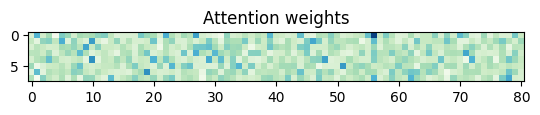

In [70]:
_, o, vl_toks, ws = encoder._encode(
    input_ids=input_ids, 
    attn_mask=attn_mask, 
    token_type_ids=token_type_ids, 
    imgs=imgs, 
    return_vl_tokens=True
)

print(o.shape, ws.shape)

pyplot.imshow(ws[0].cpu().detach().numpy(), cmap='GnBu')
pyplot.title(f'Attention weights')
pyplot.show()

### Encoder forward

In [ ]:
%%time

text_enc_h_state, learned_tokens, spatial_attn_weights = encoder(
    input_ids=input_ids,
    attn_mask=attn_mask,
    token_type_ids=token_type_ids,
    imgs=imgs
)

learned_tokens.shape, text_enc_h_state.shape, spatial_attn_weights.shape